In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys, os
sys.path.append('/content/drive/Othercomputers/My_Mac/sentinel')
os.chdir('/content/drive/Othercomputers/My_Mac/sentinel')

!pip install -q torch torchvision matplotlib numpy tqdm google-cloud-storage


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch, torch.nn as nn
import numpy as np, matplotlib.pyplot as plt, json
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from typing import Dict, List, Tuple

# Custom modules
from src.python.models.pointnet2 import PointNet2SemanticSegmentation
from src.python.datasets.semantic_kitti import SemanticKITTIDataset
from src.python.datasets.data_augmentation import AdverseWeatherAugmentation
from src.python.utils.metrics import MetricTracker, robustness_score, print_metrics
from src.python.utils.visualization import visualize_pointcloud
from src.python.config.training_config import TrainingConfig


In [3]:
class AdverseWeatherDataset(Dataset):
    """Wraps a base dataset and injects synthetic weather effects."""
    def __init__(self, base_dataset, weather_type='rain', intensity=0.5):
        self.base_dataset = base_dataset
        self.weather_type = weather_type
        self.intensity = intensity
        self.weather_aug = AdverseWeatherAugmentation()

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        points, labels = self.base_dataset[idx]
        p, l = points.numpy(), labels.numpy()

        if self.weather_type == 'rain':
            aug = self.weather_aug.add_rain_noise(p[:, :3], intensity=self.intensity, drop_ratio=0.1)
        elif self.weather_type == 'fog':
            aug = self.weather_aug.add_fog_occlusion(p[:, :3], density=self.intensity, visibility_range=50.0)
        elif self.weather_type == 'snow':
            aug = self.weather_aug.add_snow_effects(p[:, :3], accumulation=self.intensity, flake_ratio=0.05)
        elif self.weather_type == 'dust':
            aug = self.weather_aug.add_dust_storm(p[:, :3], intensity=self.intensity, particle_ratio=0.15)
        else:
            aug = p[:, :3]

        if len(aug) != len(l):
            if len(aug) > len(l):
                l = np.concatenate([l, np.zeros(len(aug) - len(l), dtype=l.dtype)])
            else:
                l = l[:len(aug)]

        if aug.shape[1] == 3:
            aug = np.hstack([aug, np.ones((aug.shape[0], 1), dtype=np.float32)])

        return torch.from_numpy(aug).float(), torch.from_numpy(l).long()


In [4]:
config = TrainingConfig()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

CLASS_NAMES = [
    'unlabeled','car','bicycle','motorcycle','truck','other-vehicle','person',
    'bicyclist','motorcyclist','road','parking','sidewalk','other-ground',
    'building','fence','vegetation','trunk','terrain','pole','traffic-sign'
]

model = PointNet2SemanticSegmentation(num_classes=config.get('model.num_classes'))
ckpt_path = os.path.join(config.get('paths.checkpoint_dir'), 'best_model.pth')
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    print(f"Loaded model from epoch {ckpt['epoch']}")
else:
    print("⚠️ No trained model found – using random weights.")
model = model.to(device).eval()


Using device: cpu
Loaded model from epoch 1


In [5]:
from google.colab import auth
auth.authenticate_user()

base_dataset = SemanticKITTIDataset(
    root_dir=config.get('paths.data_dir'),
    split='val',
    use_gcs=True,
    bucket_name=config.get('gcs.bucket_name'),
    use_intensity=True
)

print(f"Full dataset: {len(base_dataset)} samples")
subset_size = min(100, len(base_dataset))
idxs = np.random.choice(len(base_dataset), subset_size, replace=False)
base_dataset = torch.utils.data.Subset(base_dataset, idxs)
print(f"Using subset of {subset_size} samples for simulation")


Full dataset: 4071 samples
Using subset of 100 samples for simulation


In [6]:
def evaluate_weather_condition(model, dataset, device, weather_type, intensity):
    weather_dataset = AdverseWeatherDataset(dataset, weather_type, intensity)
    loader = DataLoader(weather_dataset, batch_size=1, shuffle=False, num_workers=0)
    tracker = MetricTracker(num_classes=20, ignore_index=-1)

    model.eval()
    with torch.no_grad():
        for pts, lbl in tqdm(loader, desc=f"{weather_type.capitalize()} (i={intensity})"):
            if pts.shape[1] > 50000:
                idx = torch.randperm(pts.shape[1])[:50000]
                pts, lbl = pts[:, idx], lbl[:, idx]
            pts, lbl = pts.to(device), lbl.to(device)
            try:
                pred = model(pts)
                tracker.update(pred.argmax(-1), lbl)
            except Exception as e:
                print("Error:", e); continue

    m = tracker.get_metrics()
    m['robustness_score'] = robustness_score(m)
    return m


In [7]:
print("Evaluating baseline performance (no weather effects)...")
baseline_metrics = evaluate_weather_condition(model, base_dataset, device, 'none', 0.0)
print(f"Baseline mIoU={baseline_metrics['mean_iou']:.3f}, FPR={baseline_metrics['mean_fpr']:.3f}")


Evaluating baseline performance (no weather effects)...


None (i=0.0): 100%|██████████| 100/100 [16:02<00:00,  9.63s/it]

Baseline mIoU=0.005, FPR=0.049


In [8]:
weather_conditions = {
    'rain':[0.3,0.5,0.7],'fog':[0.2,0.4,0.6],'snow':[0.2,0.3,0.4],'dust':[0.3,0.4,0.5]
}
results={'baseline':baseline_metrics}

for w,ints in weather_conditions.items():
    results[w]={}
    print(f"\nTesting {w.upper()} conditions\n{'='*40}")
    for i in ints:
        print(f"→ {w} @ intensity={i}")
        r = evaluate_weather_condition(model, base_dataset, device, w, i)
        results[w][i]=r
        print(f"mIoU={r['mean_iou']:.3f}, FPR={r['mean_fpr']:.3f}, Robust={r['robustness_score']:.3f}")



Testing RAIN conditions
→ rain @ intensity=0.3


Rain (i=0.3): 100%|██████████| 100/100 [16:43<00:00, 10.03s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ rain @ intensity=0.5


Rain (i=0.5): 100%|██████████| 100/100 [16:20<00:00,  9.81s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ rain @ intensity=0.7


Rain (i=0.7): 100%|██████████| 100/100 [16:08<00:00,  9.68s/it]


mIoU=0.000, FPR=0.050, Robust=0.475

Testing FOG conditions
→ fog @ intensity=0.2


Fog (i=0.2): 100%|██████████| 100/100 [15:44<00:00,  9.45s/it]


mIoU=0.001, FPR=0.050, Robust=0.475
→ fog @ intensity=0.4


Fog (i=0.4): 100%|██████████| 100/100 [14:46<00:00,  8.87s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ fog @ intensity=0.6


Fog (i=0.6): 100%|██████████| 100/100 [14:04<00:00,  8.45s/it]


mIoU=0.000, FPR=0.050, Robust=0.475

Testing SNOW conditions
→ snow @ intensity=0.2


Snow (i=0.2): 100%|██████████| 100/100 [14:55<00:00,  8.96s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ snow @ intensity=0.3


Snow (i=0.3): 100%|██████████| 100/100 [14:50<00:00,  8.91s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ snow @ intensity=0.4


Snow (i=0.4): 100%|██████████| 100/100 [14:27<00:00,  8.67s/it]


mIoU=0.000, FPR=0.050, Robust=0.475

Testing DUST conditions
→ dust @ intensity=0.3


Dust (i=0.3): 100%|██████████| 100/100 [13:55<00:00,  8.35s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ dust @ intensity=0.4


Dust (i=0.4): 100%|██████████| 100/100 [13:37<00:00,  8.17s/it]


mIoU=0.000, FPR=0.050, Robust=0.475
→ dust @ intensity=0.5


Dust (i=0.5): 100%|██████████| 100/100 [13:15<00:00,  7.95s/it]

mIoU=0.000, FPR=0.050, Robust=0.475


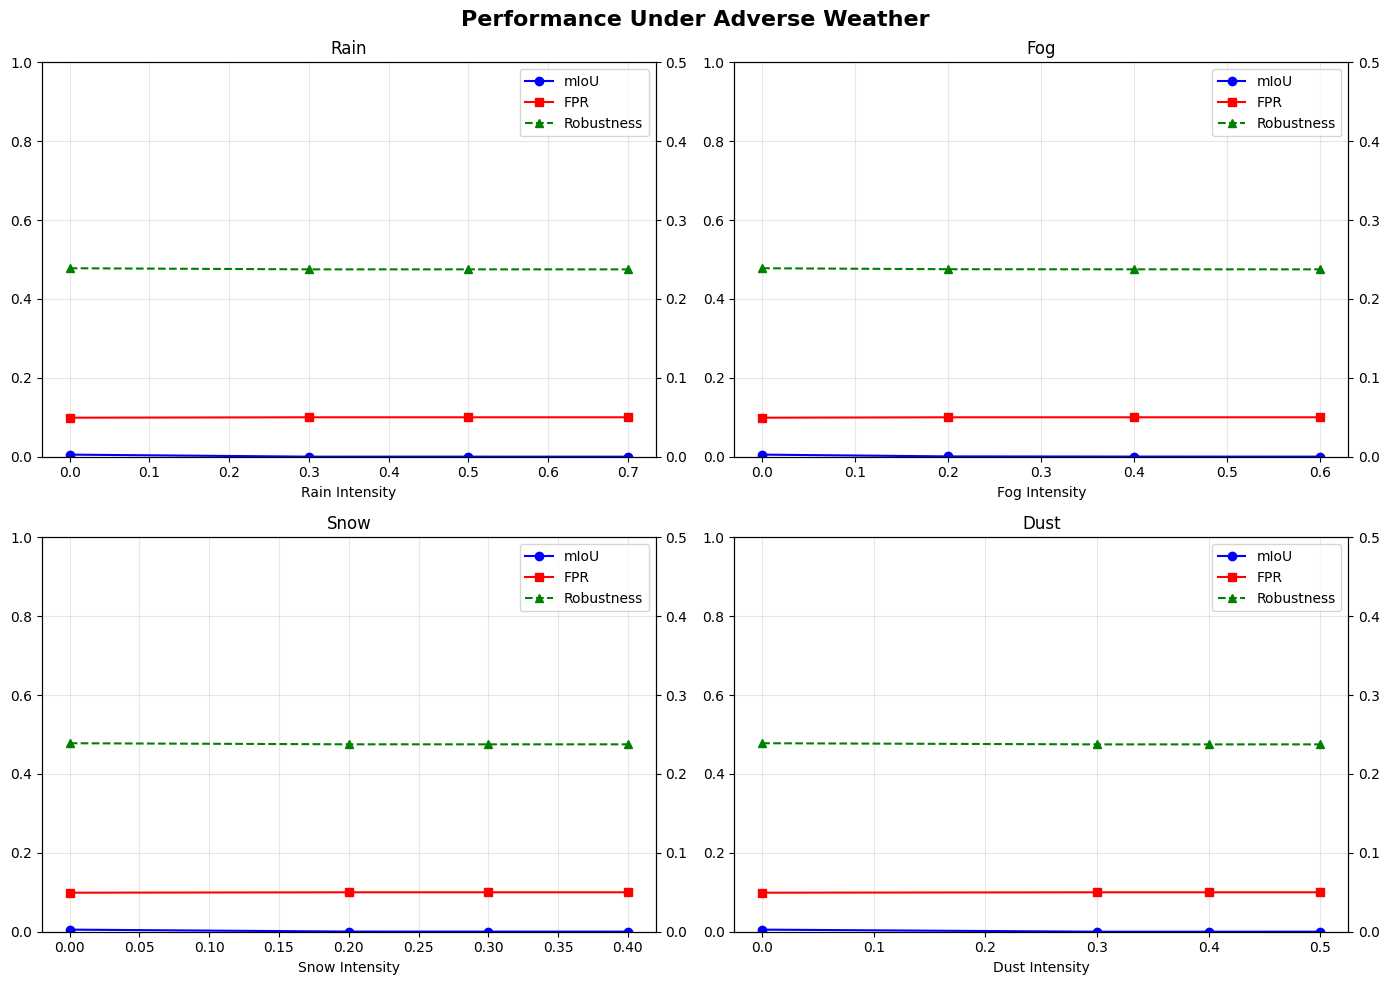

In [9]:
def plot_weather_results(results):
    fig,axes=plt.subplots(2,2,figsize=(14,10))
    fig.suptitle('Performance Under Adverse Weather',fontsize=16,fontweight='bold')
    weathers=['rain','fog','snow','dust']
    for k,w in enumerate(weathers):
        ax=axes[k//2,k%2]
        if w not in results: continue
        ints=sorted(results[w].keys())
        m=[results[w][i]['mean_iou'] for i in ints]
        f=[results[w][i]['mean_fpr'] for i in ints]
        r=[results[w][i]['robustness_score'] for i in ints]
        ints=[0]+ints
        m=[results['baseline']['mean_iou']]+m
        f=[results['baseline']['mean_fpr']]+f
        r=[results['baseline']['robustness_score']]+r
        ax2=ax.twinx()
        l1=ax.plot(ints,m,'b-o',label='mIoU')
        l2=ax2.plot(ints,f,'r-s',label='FPR')
        l3=ax.plot(ints,r,'g--^',label='Robustness')
        ax.set_xlabel(f'{w.capitalize()} Intensity');ax.set_ylim(0,1)
        ax2.set_ylim(0,0.5);ax.grid(True,alpha=0.3)
        lines=l1+l2+l3;labels=[l.get_label() for l in lines]
        ax.legend(lines,labels,loc='best')
        ax.set_title(w.capitalize())
    plt.tight_layout();plt.savefig('adverse_weather_results.png',dpi=150,bbox_inches='tight');plt.show()

plot_weather_results(results)


In [10]:
def create_comparison_table(results):
    print("\n"+"="*80)
    print("ADVERSE WEATHER PERFORMANCE COMPARISON")
    print("="*80)
    print(f"{'Condition':<15}{'Intensity':<10}{'mIoU':<10}{'FPR':<10}{'Robust':<10}{'ΔmIoU':<10}")
    print("-"*80)
    base_m,base_f=results['baseline']['mean_iou'],results['baseline']['mean_fpr']
    print(f"{'Baseline':<15}{'-':<10}{base_m:<10.3f}{base_f:<10.3f}{results['baseline']['robustness_score']:<10.3f}{'0%':<10}")
    for w in ['rain','fog','snow','dust']:
        if w in results:
            for i in sorted(results[w].keys()):
                m=results[w][i]
                d=((m['mean_iou']-base_m)/base_m)*100
                print(f"{w.capitalize():<15}{i:<10.1f}{m['mean_iou']:<10.3f}{m['mean_fpr']:<10.3f}{m['robustness_score']:<10.3f}{d:+.1f}%")
    print("="*80)

create_comparison_table(results)



ADVERSE WEATHER PERFORMANCE COMPARISON
Condition      Intensity mIoU      FPR       Robust    ΔmIoU     
--------------------------------------------------------------------------------
Baseline       -         0.005     0.049     0.478     0%        
Rain           0.3       0.000     0.050     0.475     -96.6%
Rain           0.5       0.000     0.050     0.475     -95.9%
Rain           0.7       0.000     0.050     0.475     -98.5%
Fog            0.2       0.001     0.050     0.475     -84.4%
Fog            0.4       0.000     0.050     0.475     -93.4%
Fog            0.6       0.000     0.050     0.475     -95.7%
Snow           0.2       0.000     0.050     0.475     -92.1%
Snow           0.3       0.000     0.050     0.475     -94.4%
Snow           0.4       0.000     0.050     0.475     -95.2%
Dust           0.3       0.000     0.050     0.475     -99.1%
Dust           0.4       0.000     0.050     0.475     -98.9%
Dust           0.5       0.000     0.050     0.475     -98.0%


Visualizing weather effects...


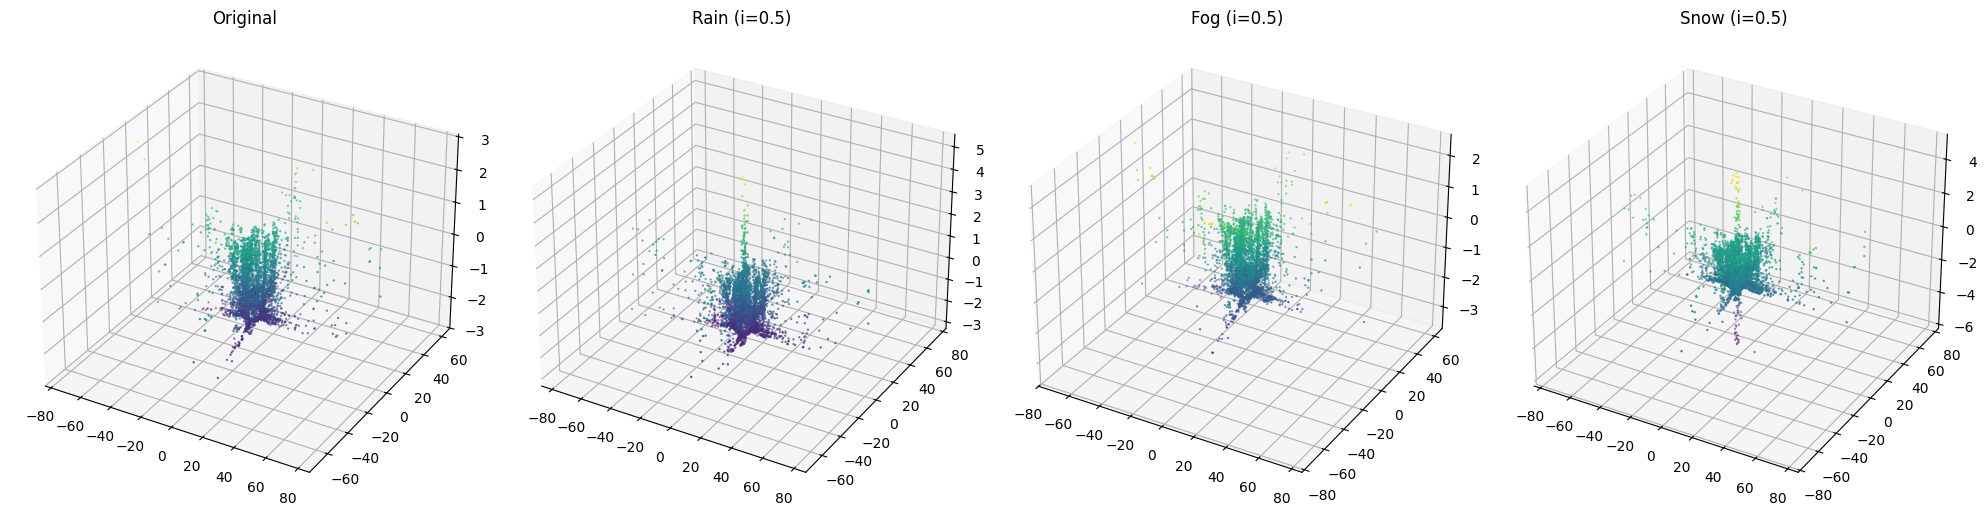

In [11]:
def visualize_weather_effects(dataset,weathers=['rain','fog','snow'],intensity=0.5):
    pts,_=dataset[0];p=pts.numpy()[:,:3]
    aug=AdverseWeatherAugmentation()
    fig,axes=plt.subplots(1,len(weathers)+1,figsize=(5*(len(weathers)+1),5),subplot_kw={'projection':'3d'})
    sidx=np.random.choice(len(p),min(5000,len(p)),replace=False)
    axes[0].scatter(p[sidx,0],p[sidx,1],p[sidx,2],c=p[sidx,2],s=0.5)
    axes[0].set_title("Original")
    for i,w in enumerate(weathers):
        if w=='rain':pw=aug.add_rain_noise(p,intensity)
        elif w=='fog':pw=aug.add_fog_occlusion(p,intensity)
        elif w=='snow':pw=aug.add_snow_effects(p,intensity)
        else:pw=p
        sidx=np.random.choice(len(pw),min(5000,len(pw)),replace=False)
        axes[i+1].scatter(pw[sidx,0],pw[sidx,1],pw[sidx,2],c=pw[sidx,2],s=0.5)
        axes[i+1].set_title(f"{w.capitalize()} (i={intensity})")
    plt.tight_layout();plt.show()

print("Visualizing weather effects...")
visualize_weather_effects(base_dataset)


In [12]:
out_json={'baseline':{k:float(v) for k,v in results['baseline'].items() if k.startswith('mean') or k=='robustness_score'}}
for w in ['rain','fog','snow','dust']:
    if w in results:
        out_json[w]={str(i):{k:float(v) for k,v in results[w][i].items() if k.startswith('mean') or k=='robustness_score'} for i in results[w]}

path=os.path.join(config.get('paths.log_dir'),'adverse_weather_results.json')
with open(path,'w') as f:json.dump(out_json,f,indent=2)
print(f"\nResults saved to {path}")

deg=[]
for w in ['rain','fog','snow','dust']:
    if w in results:
        for i in results[w]:
            d=(results['baseline']['mean_iou']-results[w][i]['mean_iou'])/results['baseline']['mean_iou']
            deg.append(d)
avg=np.mean(deg)*100
print("\n"+"="*60)
print("ADVERSE WEATHER SIMULATION COMPLETE")
print("="*60)
print(f"Average mIoU degradation: {avg:.1f}%")
print("Baseline model would benefit from geometric refinement to improve robustness.")



Results saved to /content/drive/MyDrive/project-sentinel/logs/adverse_weather_results.json

ADVERSE WEATHER SIMULATION COMPLETE
Average mIoU degradation: 95.2%
Baseline model would benefit from geometric refinement to improve robustness.
